## SCORE NETWORK

In [ ]:
#https://github.com/adasgupta94/USC_UQ_SummerSchool2023/tree/main

In [1]:
import time
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output
from IPython import display
from colour import Color


torch.manual_seed(0)
np.random.seed(0)
#if torch.cuda.is_available():
#    torch.cuda.manual_seed_all(0)
#torch.backends.cudnn.benchmark = True

class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(nn.Linear(3, 32),nn.GELU())
        self.embedding_layer = nn.Embedding(n_steps, 32)
        self.norm1 = nn.BatchNorm1d(32, affine=False)
        self.shift = nn.Parameter(torch.zeros(32))
        self.shift.data.normal_(1, 0.02)

        self.linear_model2 = nn.Sequential(nn.Linear(32, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 3))       
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)    
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        #embedding = self.embedding_layer(idx)
        #output = self.linear_model2(output + embedding)
        output = self.norm1(output)
        output = output + self.shift.view(1,-1).repeat(output.shape[0],1)
        output = self.linear_model2(output)
        output = output / used_sigmas

        return (output, target, used_sigmas) if get_target else output

/tmp/ipykernel_125134/3581120053.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


## ANNEALED LANGEVIN DYNAMICS MCMC SAMPLER

In [2]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sample = (torch.rand([sampling_number,3]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

## UTILITY FUNCTIONS

In [3]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def scatter(sample, only_final, scatter_range = [-10, 10], title=None, save_name=None):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y, scatter_z = scatter[:,0], scatter[:,1], scatter[:,2]
        
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(projection='3d')

        ax.set_xlim(scatter_range)
        ax.set_ylim(scatter_range)
        ax.set_zlim([0, 80])

        plt.rc('axes', unicode_minus=False)
        ax.scatter(scatter_x, scatter_y, scatter_z, s=10)
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig = plt.figure(figsize=(step_size * 4, 4), constrained_layout = True)
        
        for i in range(step_size):
            axs = fig.add_subplot(1, step_size, i+1, projection='3d')
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y, scatter_z = scatter[:,0], scatter[:,1], scatter[:,2]
            axs.scatter(scatter_x, scatter_y, scatter_z, s=10)
            axs.set_xlim(scatter_range)
            axs.set_ylim(scatter_range)
            axs.set_zlim([0,80])
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
     

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


## DATA LOADER

In [4]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, total_len = 1000000):
        self.total_len = total_len
        self.data = torch.zeros((total_len, 3))
        for i in range(total_len):
            self.data[i,2] = 100.0*torch.rand(1)
            self.data[i,1] = 5.0*torch.sin(0.25*self.data[i,2]) + 0.2*torch.randn(1)
            self.data[i,0] = 5.0*torch.cos(0.25*self.data[i,2]) + 0.2*torch.randn(1)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self.data[idx]
        return data

## HYPERPARAMETERS

In [5]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 50
n_steps = 10
annealed_step = 100
device = torch.device('cpu')
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

scatter_range = [-10, 10]
total_iteration = 150000
display_iteration = 7500
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

## CREATE AND PLOT TRAINING DATA

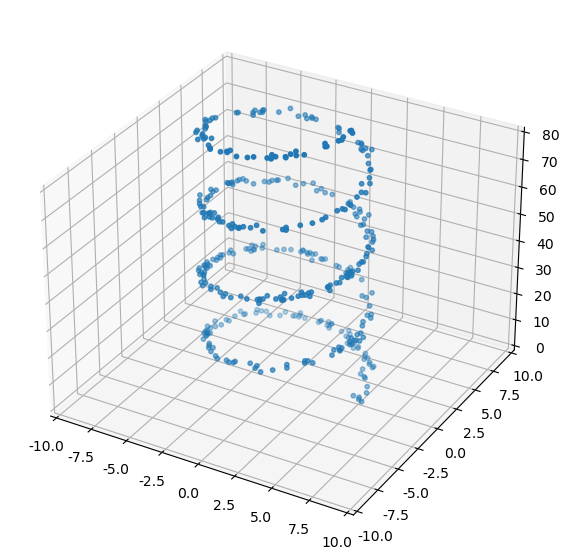

In [8]:
batch_size = 128
dataset = DataSet(total_len=400)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

xx = [dataset.__getitem__(i) for i in range(len(dataset))]
xx = torch.stack(xx, dim=0)
scatter(xx, True, save_name='./toy3d/dataset.jpg')

## TRAINING

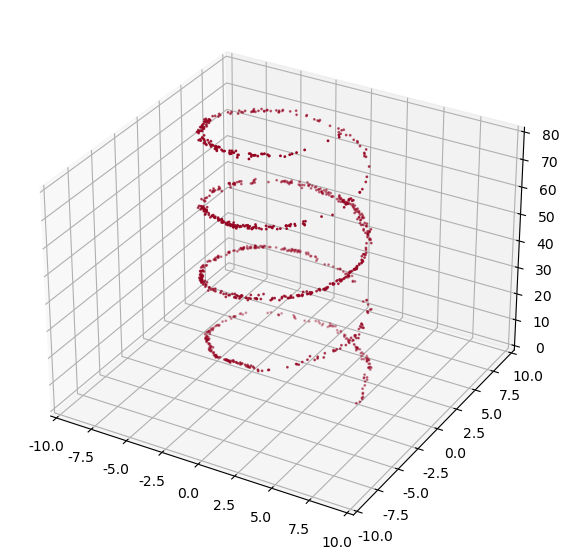

In [12]:
flag = 0
current_iteration = 0
red = Color("red")

color1 = "#8A5AC2"
color2 = "#960019"
color = get_color_gradient(color1, color2, int(total_iteration/display_iteration) + 2)

while current_iteration != total_iteration:
    try:
        data = next(dataiterator)
    except:
        dataiterator = iter(dataloader)
        data = next(dataiterator)
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        clear_output(wait=True)
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(projection='3d')
        ax.set_xlim(scatter_range)
        ax.set_ylim(scatter_range)
        ax.set_zlim([0, 80])
        plt.rc('axes', unicode_minus=False)
        ax.scatter(sample[:,0].detach().cpu().numpy(), sample[:,1].detach().cpu().numpy(), sample[:,2].detach().cpu().numpy(), s=1, c=color[int(current_iteration/display_iteration)])
        plt.savefig("./toy3d/images_" + str(current_iteration) + ".jpg")
        plt.show()
        #display.display(plt.gcf())
        #time.sleep(1)
        #time.sleep(4)
        #plt.cla() 


## SAMPLING

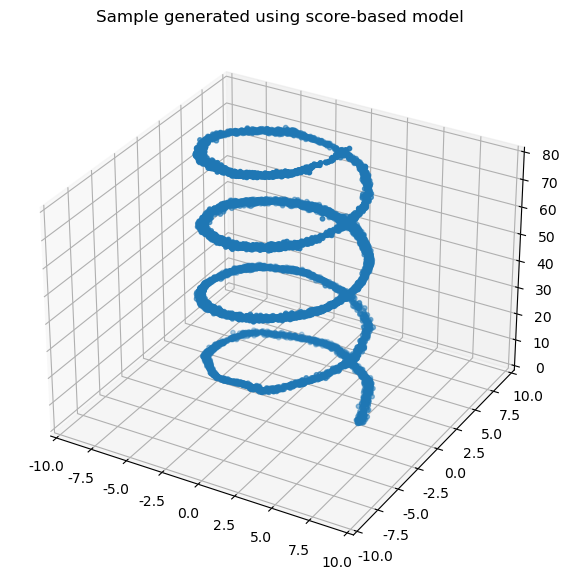

In [56]:

sampling_number = 10000
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range= scatter_range,title=r'Sample generated using score-based model', save_name='./toy3d/'+'fake.jpg')

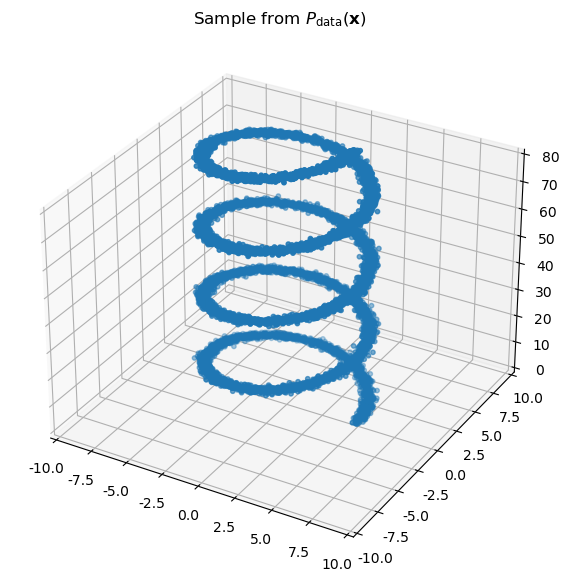

In [14]:
dataset2 = DataSet(total_len=10000)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, drop_last = True)
dataiterator2 = iter(dataloader2)
xx = [dataset2.__getitem__(i) for i in range(len(dataset2))]
xx = torch.stack(xx, dim=0)
scatter(xx, True, title=r'Sample from $P_{\mathrm{data}}(\mathbf{x})$', save_name='./toy3d/'+'real.jpg')

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def update_plot(i, data, scat):
    scat._offsets3d = (data[i,:,0].detach().cpu().numpy(),data[i,:,1].detach().cpu().numpy(),data[i,:,2].detach().cpu().numpy())
    return scat

sampling_number = 10000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y, scatter_z = scatter_point[:,0], scatter_point[:,1], scatter_point[:,2]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(scatter_range)
ax.set_ylim(scatter_range)
ax.set_zlim([0,80])

scat = ax.scatter(scatter_x, scatter_y, scatter_z, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=1000)
ani.save('./toy3d/toy3d.gif')
HTML(ani.to_jshtml())

# Geodesic 

In [24]:
score_model = model

In [33]:
from torch_geometry.riemannian.prob_geodesics import ProbGEORCE, ProbEuclideanGEORCE
from torch_geometry.riemannian.prob_geodesics import TorchOptimization, TorchEuclideanOptimization

In [49]:
def score_model(z,t):
    
    return model(z.reshape(-1,3), t)
    

In [103]:
t0 = 0.01
M_ProbGEORCE = ProbEuclideanGEORCE(score_fun = lambda z: score_model(z,t0),#lambda z: score_fun(z,t0),
                                    init_fun=None,#lambda *args: init_val,#None,
                                    lam=50.0,#,t0**4,
                                    T=100,
                                    max_iter=1000,
                                    line_search_params={'rho': 0.5, 'max_iter': 100},
                                   )

In [104]:
t0 = 0.01
M_ProbTorch = TorchEuclideanOptimization(score_fun = lambda z: score_model(z,t0),#lambda z: score_fun(z,t0),
                                        init_fun=None,#lambda *args: init_val,#None,
                                        lam=10.0,#,t0**4,
                                        T=100,
                                        max_iter=1000,
                                       )

In [105]:
z0 = DataSet(total_len=10).__getitem__(1)
zT = DataSet(total_len=10).__getitem__(-1)

In [106]:
test = M_ProbGEORCE(z0,zT)

33.5546760559082
0
9
3.426729202270508
1
8
3.096977949142456
2
10
2.09371280670166
3
10
1.926792860031128
4
8
1.8968887329101562
5
10
1.7458069324493408
6
9
1.7245937585830688
7
10
1.6816624402999878
8
8
1.669360637664795
9
10
1.6152445077896118
10
9
1.6019155979156494
11
10
1.5825326442718506
12
8
1.5676562786102295
13
10
1.5429707765579224
14
9
1.5329245328903198
15
9
1.5291502475738525
16
10
1.5118690729141235
17
9
1.5037293434143066
18
9
1.5005245208740234
19
10
1.4866969585418701
20
9
1.4797532558441162
21
9
1.4762053489685059
22
10
1.4660710096359253
23
9
1.4601343870162964
24
9
1.4568533897399902
25
10
1.448705792427063
26
9
1.4434847831726074
27
9
1.4401395320892334
28
10
1.433944821357727
29
9
1.4293444156646729
30
9
1.4261980056762695
31
10
1.4211740493774414
32
8
1.417067050933838
33
10
1.4102193117141724
34
9
1.407036542892456
35
10
1.4038538932800293
36
8
1.3987646102905273
37
10
1.3947851657867432
38
9
1.391833782196045
39
9
1.3897206783294678
40
10
1.3865926265716553
41


30
1.2836251258850098
326
30
1.2836251258850098
327
30
1.2836251258850098
328
30
1.2836251258850098
329
30
1.2836251258850098
330
30
1.2836251258850098
331
30
1.2836251258850098
332
30
1.2836251258850098
333
30
1.2836251258850098
334
30
1.2836251258850098
335
30
1.2836251258850098
336
30
1.2836251258850098
337
30
1.2836251258850098
338
30
1.2836251258850098
339
30
1.2836251258850098
340
30
1.2836251258850098
341
30
1.2836251258850098
342
30
1.2836251258850098
343
30
1.2836251258850098
344
30
1.2836251258850098
345
30
1.2836251258850098
346
30
1.2836251258850098
347
30
1.2836251258850098
348
30
1.2836251258850098
349
30
1.2836251258850098
350
30
1.2836251258850098
351
30
1.2836251258850098
352
30
1.2836251258850098
353
30
1.2836251258850098
354
30
1.2836251258850098
355
30
1.2836251258850098
356
30
1.2836251258850098
357
30
1.2836251258850098
358
30
1.2836251258850098
359
30
1.2836251258850098
360
30
1.2836251258850098
361
30
1.2836251258850098
362
30
1.2836251258850098
363
30
1.2836251

30
1.2836251258850098
645
30
1.2836251258850098
646
30
1.2836251258850098
647
30
1.2836251258850098
648
30
1.2836251258850098
649
30
1.2836251258850098
650
30
1.2836251258850098
651
30
1.2836251258850098
652
30
1.2836251258850098
653
30
1.2836251258850098
654
30
1.2836251258850098
655
30
1.2836251258850098
656
30
1.2836251258850098
657
30
1.2836251258850098
658
30
1.2836251258850098
659
30
1.2836251258850098
660
30
1.2836251258850098
661
30
1.2836251258850098
662
30
1.2836251258850098
663
30
1.2836251258850098
664
30
1.2836251258850098
665
30
1.2836251258850098
666
30
1.2836251258850098
667
30
1.2836251258850098
668
30
1.2836251258850098
669
30
1.2836251258850098
670
30
1.2836251258850098
671
30
1.2836251258850098
672
30
1.2836251258850098
673
30
1.2836251258850098
674
30
1.2836251258850098
675
30
1.2836251258850098
676
30
1.2836251258850098
677
30
1.2836251258850098
678
30
1.2836251258850098
679
30
1.2836251258850098
680
30
1.2836251258850098
681
30
1.2836251258850098
682
30
1.2836251

30
1.2836251258850098
962
30
1.2836251258850098
963
30
1.2836251258850098
964
30
1.2836251258850098
965
30
1.2836251258850098
966
30
1.2836251258850098
967
30
1.2836251258850098
968
30
1.2836251258850098
969
30
1.2836251258850098
970
30
1.2836251258850098
971
30
1.2836251258850098
972
30
1.2836251258850098
973
30
1.2836251258850098
974
30
1.2836251258850098
975
30
1.2836251258850098
976
30
1.2836251258850098
977
30
1.2836251258850098
978
30
1.2836251258850098
979
30
1.2836251258850098
980
30
1.2836251258850098
981
30
1.2836251258850098
982
30
1.2836251258850098
983
30
1.2836251258850098
984
30
1.2836251258850098
985
30
1.2836251258850098
986
30
1.2836251258850098
987
30
1.2836251258850098
988
30
1.2836251258850098
989
30
1.2836251258850098
990
30
1.2836251258850098
991
30
1.2836251258850098
992
30
1.2836251258850098
993
30
1.2836251258850098
994
30
1.2836251258850098
995
30
1.2836251258850098
996
30
1.2836251258850098
997
30
1.2836251258850098
998
30
1.2836251258850098
999
30
1.2836251

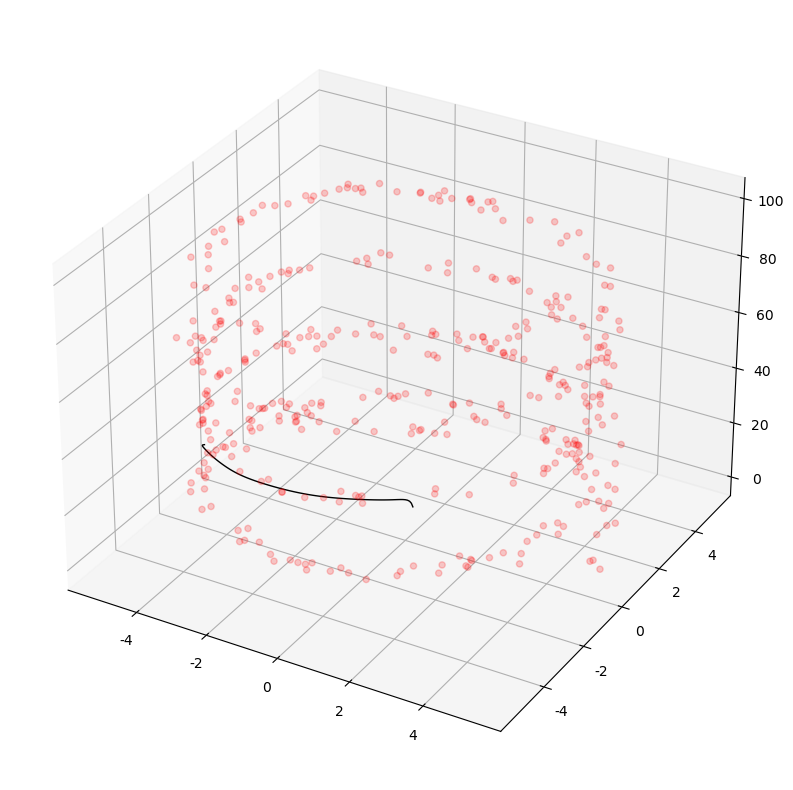

In [107]:
import matplotlib.pyplot as plt

batch_size = 128
dataset = DataSet(total_len=400)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

xx = [dataset.__getitem__(i) for i in range(len(dataset))]
xx = torch.stack(xx, dim=0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,  projection='3d')
ax.plot(test[0][:,0], test[0][:,1], test[0][:,2], linewidth=1.0, color='black')
ax.scatter(xx[:,0], xx[:,1], xx[:,2], alpha=0.2, color='red')